In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("filippgg/x-detect")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/x-detect


# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import numpy as np
from matplotlib import pyplot as plt
import pylab

from tqdm import tqdm

from PIL import Image

# Device

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Data loader

In [15]:
data_set = torchvision.datasets.ImageFolder('./gen_dataset/')

In [7]:
img_transforms = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Resize((1280, 720)),
    torchvision.transforms.ConvertImageDtype(torch.float),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(1),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Resize((1280, 720)),
    torchvision.transforms.ConvertImageDtype(torch.float),
    torchvision.transforms.Normalize(mean=1, std=-1),
])

# Class dataset

In [10]:
class ImgDataset(torch.utils.data.Dataset):
    def __init__(self, data_set, img_transforms, mask_transforms):
        super(ImgDataset, self).__init__()
        self.data_set = data_set
        self.maedian = int(len(data_set)/2)
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms

    def __getitem__(self, index):
        img = self.data_set[index][0]
        lable = self.data_set[self.maedian + index][0]

        img = self.img_transforms(img)
        lable = self.mask_transforms(lable)

        return (img, lable)

    def __len__(self):
        return self.maedian

In [16]:
data = ImgDataset(data_set, img_transforms, mask_transforms)

train test valid split

In [17]:
train, val, test = torch.utils.data.random_split(data, [920, 115, 115])

dataloader

In [18]:
batch_size = 5

dataloader_train = torch.utils.data.DataLoader(train, batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(val, 1, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test, 1, shuffle=True)

Model ResNet

In [ ]:
model = torchvision.models.segmentation.fcn_resnet50(
    num_classes=1,
    weights_backbone=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
)
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

Acc

In [19]:
def img_sampl(data):
  data = data > 0.5
  data = data * 1
  data = data.float()
  return data

In [20]:
def pixel_acc(predict_tensot, lable_tensot):

    predict_tensot = img_sampl(predict_tensot)
    lable_tensot = lable_tensot

    correct_pixels = (predict_tensot == lable_tensot).count_nonzero()
    uncorrect_pixels = (predict_tensot != lable_tensot).count_nonzero()
    result = (correct_pixels / (correct_pixels + uncorrect_pixels)).item()

    return result


In [21]:
def IoU_acc(predict_tensot, lable_tensot):
  predict_binar_tensot = predict_tensot >= 0.51

  intersection = torch.logical_and(predict_binar_tensot, lable_tensot).count_nonzero()
  union = torch.logical_or(predict_binar_tensot, lable_tensot).count_nonzero()
  result = (intersection / union).item()

  return result

In [22]:
def accuracy_model(model, data_loader):
    score = {
        'Pixel Acc': [],
        'IoU Acc': []
    }
    for data in tqdm(data_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        out = model(inputs)

        score['Pixel Acc'].append(pixel_acc(out['out'], labels))
        score['IoU Acc'].append(IoU_acc(out['out'], labels))

    score['Pixel Acc'] = np.mean(score['Pixel Acc'])
    score['IoU Acc'] = np.mean(score['IoU Acc'])

    return score

In [23]:
def train(model, valloader, trainloader, optimizer, criterion, epoch, save = False):

    loss_stats = {
        'loss_func': [],
        'Pixel Acc': [],
        'IoU Acc': [],
        'Valid Pixel Acc': [],
        'Valid IoU Acc': []
    }

    for ep in range(epoch):

        model.train()

        pixel_acc_arr = []
        iou_acc_arr = []
        running_loss = 0.0
        for data in (bar := tqdm(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs['out'], labels)
            pixel_acc_arr.append(pixel_acc(outputs['out'], labels))
            iou_acc_arr.append(IoU_acc(outputs['out'], labels))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            bar.set_description(f'epoch: {ep}\tloss: {running_loss:.3F}')

        loss_stats['loss_func'].append(running_loss)
        loss_stats['Pixel Acc'].append(np.mean(pixel_acc_arr))
        loss_stats['IoU Acc'].append(np.mean(iou_acc_arr))

        model.eval()

        valid_acc = accuracy_model(model, valloader)
        loss_stats['Valid Pixel Acc'].append(valid_acc['Pixel Acc'])
        loss_stats['Valid IoU Acc'].append(valid_acc['IoU Acc'])
    return loss_stats

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
stats = train(
    model,
    dataloader_val,
    dataloader_train,
    optimizer,
    criterion,
    20
)

100%|██████████| 115/115 [00:06<00:00, 17.89it/s]


result

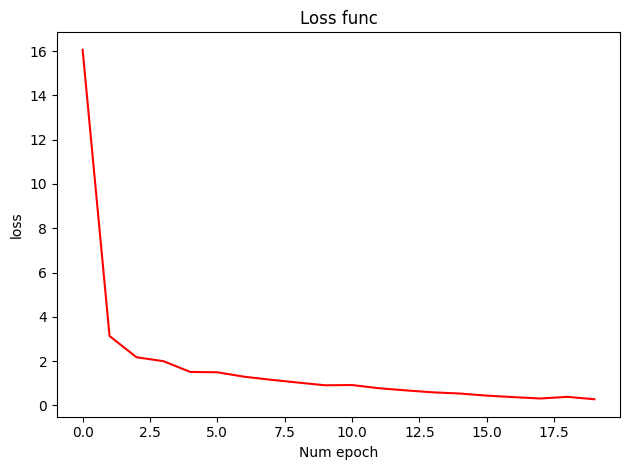

In [ ]:
plt.title('Loss func')
plt.xlabel('Num epoch')
plt.ylabel('loss')

plt.plot(stats['loss_func'], 'r')

plt.tight_layout()

plt.show()

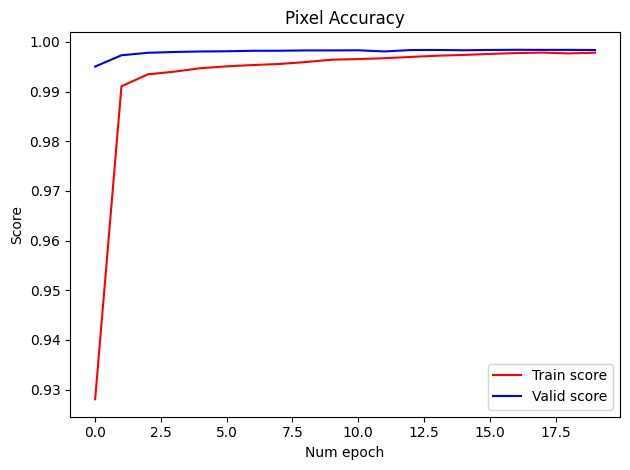

In [ ]:
plt.title('Pixel Accuracy')
plt.xlabel('Num epoch')
plt.ylabel('Score')

plt.plot(stats['Pixel Acc'], 'r', label='Train score')
plt.plot(stats['Valid Pixel Acc'], 'b', label='Valid score')

plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

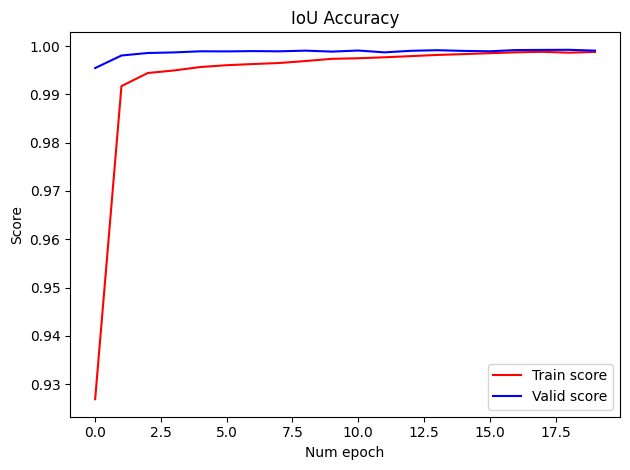

In [ ]:
plt.title('IoU Accuracy')
plt.xlabel('Num epoch')
plt.ylabel('Score')

plt.plot(stats['IoU Acc'], 'r', label='Train score')
plt.plot(stats['Valid IoU Acc'], 'b', label='Valid score')

plt.legend(fontsize=10)
plt.tight_layout()

plt.show()

In [25]:
def test(model, test_loader, id_img=None):
    for id, data in enumerate(tqdm(test_loader)):
        if id_img != None:
            if id not in id_img:
              continue
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        trans_RGB = torchvision.transforms.ToPILImage('RGB')
        trans_L = torchvision.transforms.ToPILImage('L')

        out = model(inputs)

        fig, ax = plt.subplots(ncols=3)
        ax[0].set_title('input image')
        ax[0].axis('off')
        ax[0].imshow(trans_RGB(inputs.to('cpu')[0]))

        ax[1].set_title('lable image')
        ax[1].axis('off')
        ax[1].imshow(trans_L(labels.to('cpu')[0]))

        ax[2].set_title('output image')
        ax[2].axis('off')
        ax[2].imshow(trans_L(img_sampl(out['out']).to('cpu')[0]))

        fig.show()


In [ ]:
accuracy_model(model, dataloader_test)

100%|██████████| 115/115 [00:07<00:00, 15.11it/s]


{'Pixel Acc': np.float64(0.9967437816702801),
 'IoU Acc': np.float64(0.9973642877910448)}

 34%|███▍      | 39/115 [00:03<00:08,  9.03it/s]C:\Users\Filic\AppData\Local\Temp\ipykernel_12244\3941326343.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
100%|██████████| 115/115 [07:11<00:00,  3.76s/it] 


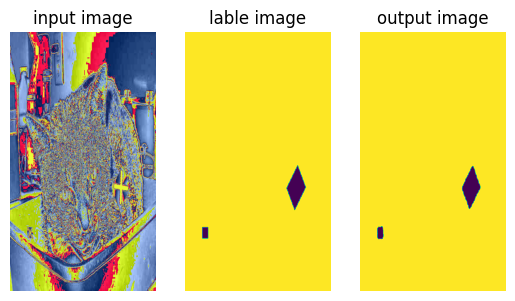

In [26]:
test(model, dataloader_test, [40])

In [ ]:
torch.save(model, 'my_model.pth')

In [ ]:
torch.save(model.state_dict(), 'my_model_dict.pth')

detect

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/image/
  inflating: data/image/00000001.png  
  inflating: data/image/00000002.png  
  inflating: data/image/00000003.png  
  inflating: data/image/00000004.png  
  inflating: data/image/00000005.png  
  inflating: data/image/00000006.png  
  inflating: data/image/00000007.png  
  inflating: data/image/00000008.png  
  inflating: data/image/00000009.png  
  inflating: data/image/00000010.png  
  inflating: data/image/00000011.png  
  inflating: data/image/00000012.png  
  inflating: data/image/00000013.png  
  inflating: data/image/00000014.png  
  inflating: data/image/00000015.png  
  inflating: data/image/00000016.png  
  inflating: data/image/00000017.png  
  inflating: data/image/00000018.png  
  inflating: data/image/00000019.png  
  inflating: data/image/00000020.png  
  inflating: data/image/00000021.png  
  inflating: data/image/00000022.png  
  inflating: data/image/00000023.png  
  inflating: data/image/00000024.png  
 

In [3]:
model = torchvision.models.segmentation.fcn_resnet50(
    num_classes=1,
    weights_backbone=torchvision.models.ResNet50_Weights.IMAGENET1K_V2
)

model.load_state_dict(torch.load('my_model.pth'))
model.to(device)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [4]:
data_set = torchvision.datasets.ImageFolder('./data/')

In [5]:
class ImgDatasetDetect(torch.utils.data.Dataset):
    def __init__(self, data_set, img_transforms):
        super(ImgDatasetDetect, self).__init__()
        self.data_set = data_set
        self.img_transforms = img_transforms

    def __getitem__(self, index):
        img = self.data_set[index][0]
        size = self.data_set[index][0].size
        img = self.img_transforms(img)

        return img, size

    def __len__(self):
        return len(self.data_set)

In [27]:
data = ImgDatasetDetect(data_set, img_transforms)

In [ ]:
dataloader_detect =  torch.utils.data.DataLoader(data, 1, shuffle=False)

In [ ]:
def detect(model, test_loader, id_img=None):
    for id, data in enumerate(tqdm(test_loader)):
        if id_img != None:
            if id not in id_img:
              continue
        inputs, size= data
        inputs = inputs.to(device)

        trans_RGB = torchvision.transforms.ToPILImage('RGB')
        trans_L = torchvision.transforms.ToPILImage('L')

        out = model(inputs)
        mask = trans_L(img_sampl(out['out']).to('cpu')[0]).resize(size)

        fig, ax = plt.subplots(ncols=2)
        ax[0].set_title('input image')
        ax[0].axis('off')
        ax[0].imshow(trans_RGB(inputs.to('cpu')[0]).resize(size))

        ax[1].set_title('output image')
        ax[1].axis('off')
        ax[1].imshow(mask)

        fig.show()
        mask.save(f'./mask/{id}.png')

In [ ]:
detect(model, dataloader_detect)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
! zip -r /mask/*


zip error: Nothing to do! (/mask/*.zip)


In [ ]:
!zip -r /content/file.zip /content/

updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/configurations/ (stored 0%)
updating: content/.config/configurations/config_default (deflated 15%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
updating: content/.config/.last_update_check.json (deflated 24%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2025.04.10/ (stored 0%)
updating: content/.config/logs/2025.04.10/13.37.12.168821.log (deflated 56%)
updating: content/.config/logs/2025.04.10/13.36.58.707211.log (deflated 86%)
updating: content/.config/logs/2025.04.10/13.36.50.556943.log (deflated 58%)
updating: content/.config/logs/2025.04.10/13.37.03.105867.log (deflated 58%)
updating: content/.config/logs/2025.04.10/13.37.11.482098.log (deflated 57%)
updating: content/.config/logs/2025.04.1

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>